# Temporal Distribution of PMC in the Nordic Seas

In [5]:
import calendar
from IPython.core.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from common_defs import nyr, winters, month_weights, START_YEAR, aliases, winter_dates, dset_names
import mypaths
from plot_utils import cc

from octant.core import TrackRun, OctantTrack
from octant.misc import SUBSETS, bin_count_tracks
import octant
octant.__version__

'0.0.13'

In [2]:
plt.style.use('paperfig.mplstyle')

In [3]:
track_runs = dict()
for (dset_name, _) in dset_names:
    TR = TrackRun()
    TR.data = OctantTrack.from_mux_df(pd.read_parquet(mypaths.procdir / f'{dset_name}_2008_2017_top10.parquet', engine='pyarrow'))
    TR.is_categorised = True
    track_runs[dset_name] = TR

### Monthly distribution

In [5]:
weight_by_days_in_month = True

In [6]:
if weight_by_days_in_month:
    weight_factor = month_weights
else:
    weight_factor = np.ones(12) / nyr

In [7]:
subsets = SUBSETS[1:]
start_mon = 10
end_mon = 4

In [8]:
all_monthly_counts = dict()
for k, TR in tqdm(track_runs.items(), desc='track runs', leave=False):
    TR_one_winter = TrackRun()

    _d = dict()
    for winter, (winter_start, winter_end) in tqdm(winter_dates.items(), desc='winters'):
        TR_one_winter.data = TR.data[(TR.data['time'] >= winter_start) & (TR.data['time'] <= winter_end)]

        monthly_counts = pd.DataFrame({subset: bin_count_tracks(TR_one_winter[subset],
                                                                                start_year=START_YEAR,
                                                                                n_winters=nyr)
                                       for subset in subsets})
        monthly_counts['month_names'] = calendar.month_name[1:]
        _d[winter] = pd.concat([monthly_counts[start_mon-1:], monthly_counts[:end_mon]])
    df = pd.concat(_d)

    all_monthly_counts[k] = df
clear_output()

In [ ]:
# a, b = all_monthly_counts['interim_run106'].groupby('month_names', sort=False).mean()[subsets].values.T
# 100 * b / a

In [17]:
mon_range = np.arange(df['month_names'].unique().shape[0])

In [18]:
width = 1/5

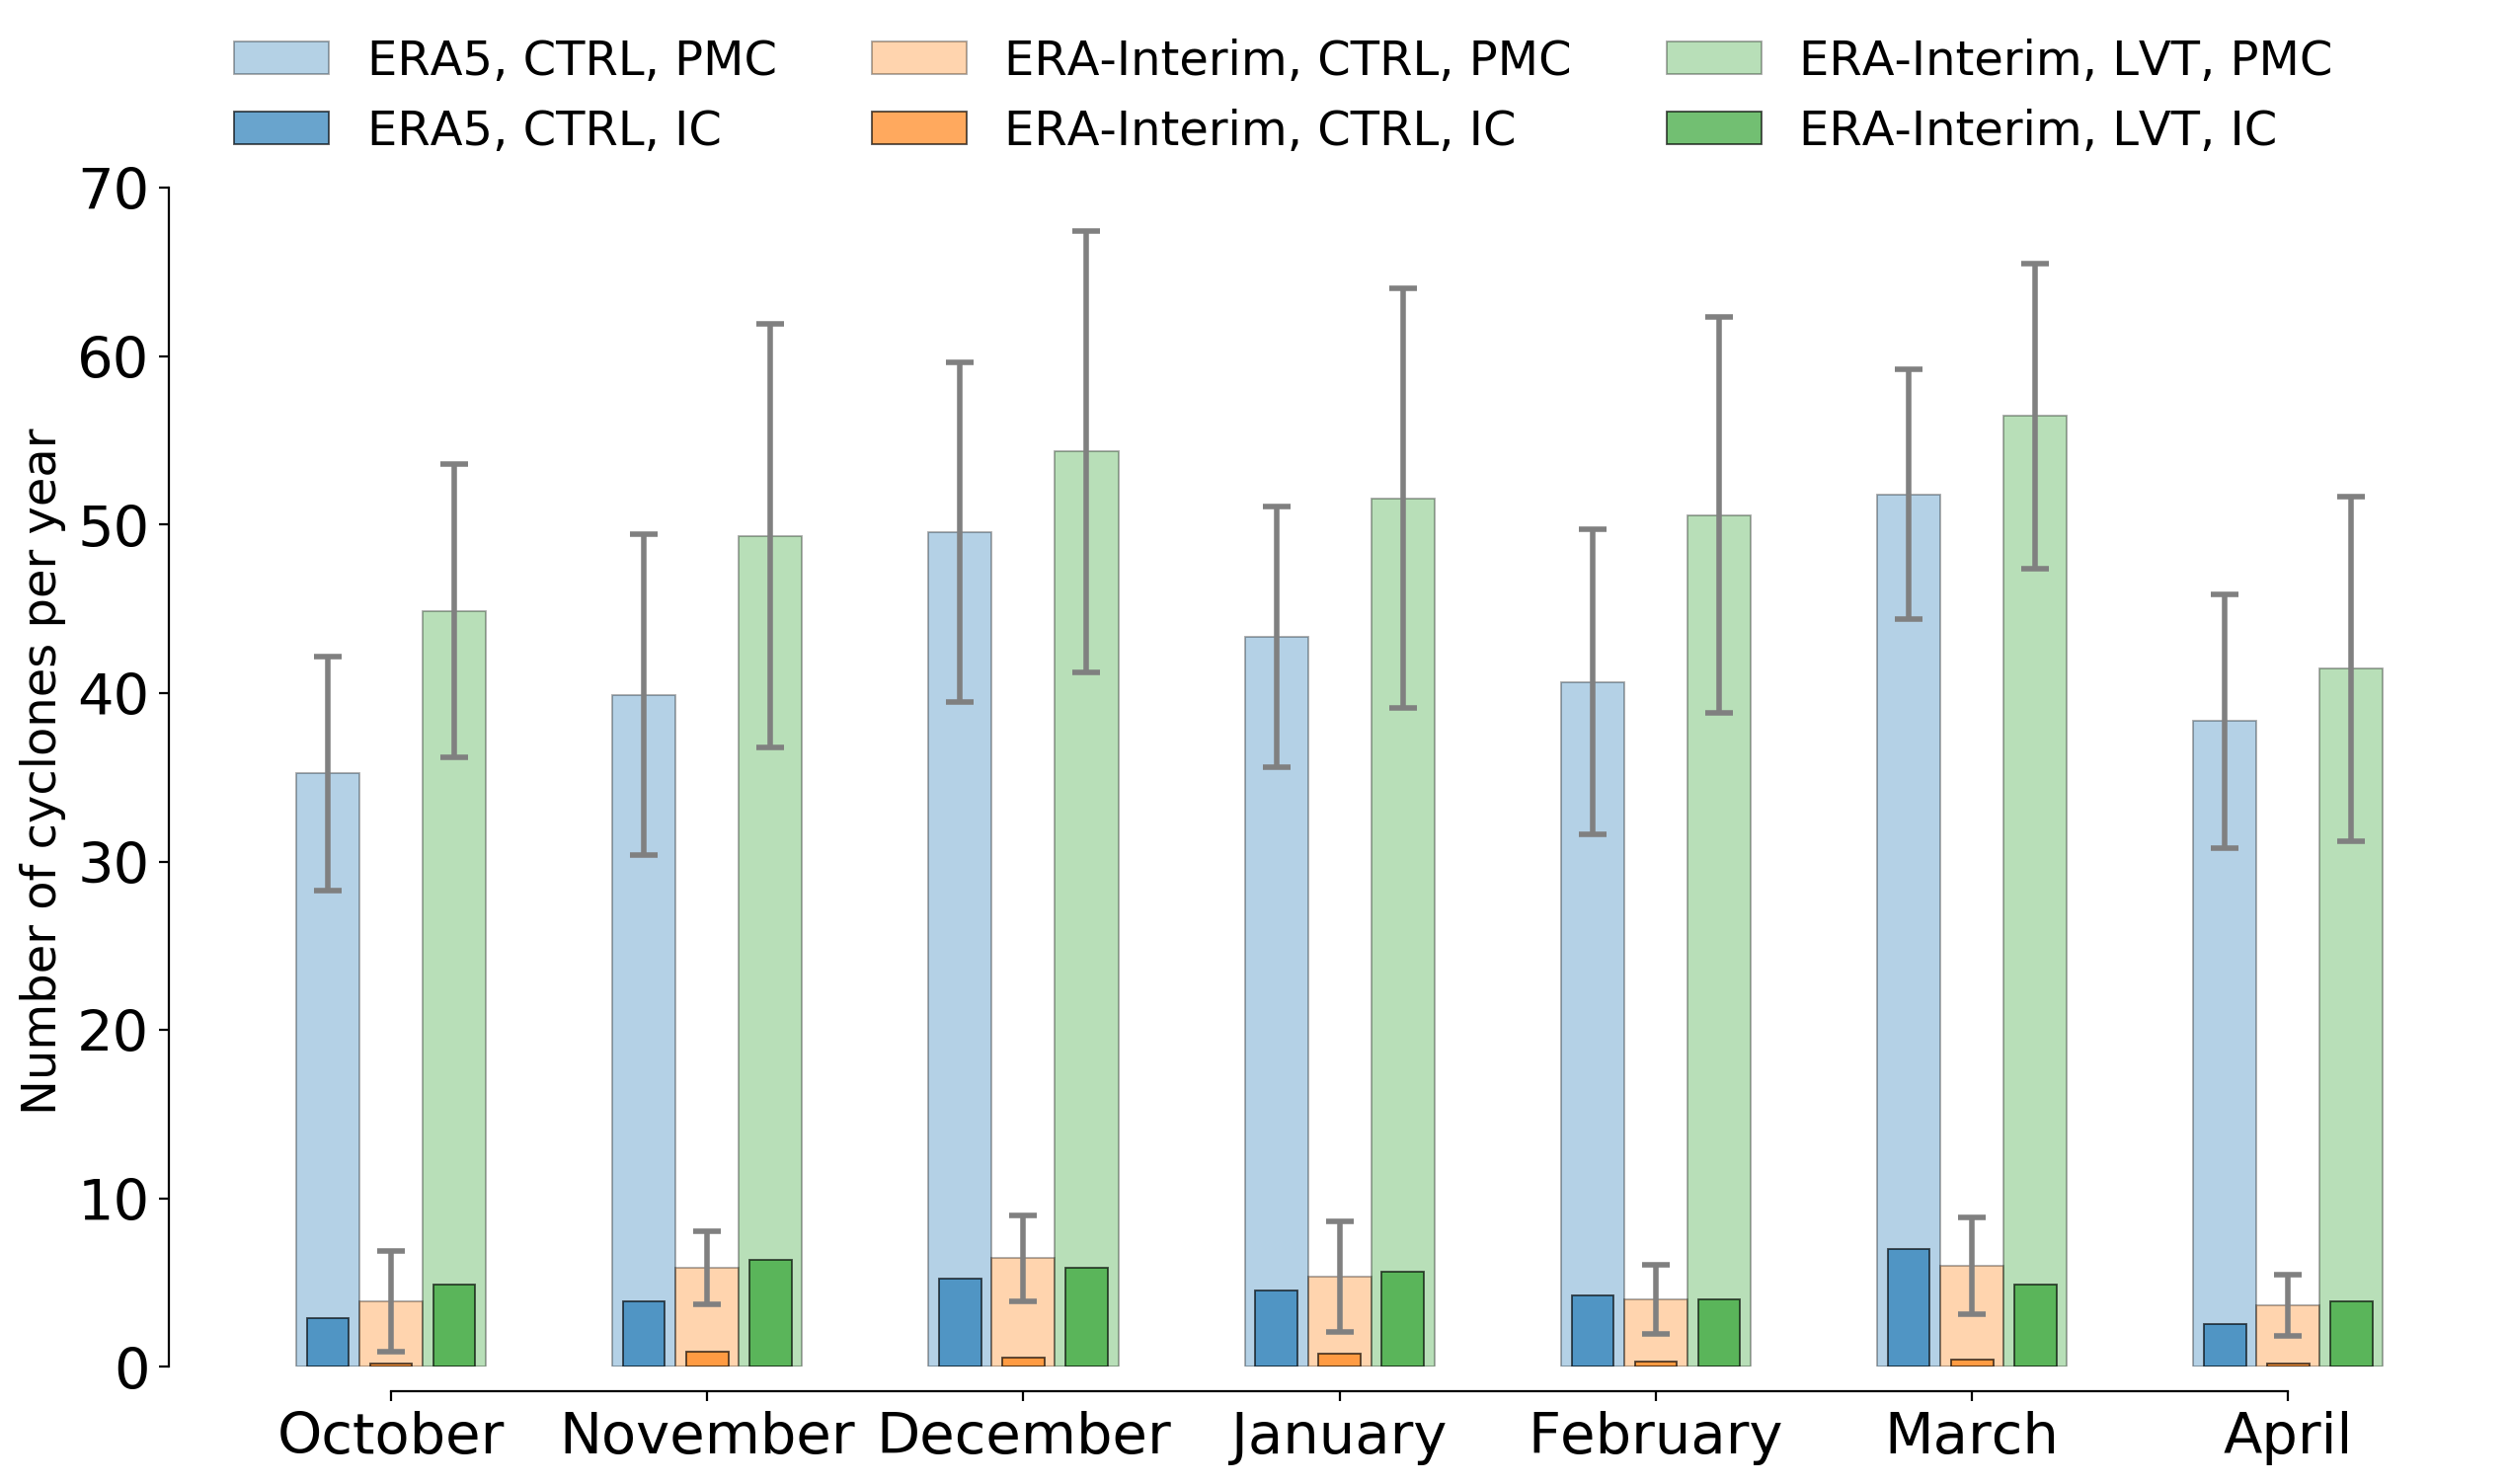

In [24]:
fig, ax = plt.subplots()

for j, ((dset_name, dset_label), color) in enumerate(zip(dset_names, cc)):
    for i, (subset) in enumerate(subsets):
        df = all_monthly_counts[dset_name][[subset, 'month_names']]
        ave = df.groupby('month_names', sort=False).mean().squeeze()
        err = df.groupby('month_names', sort=False).std().squeeze()
        
        factor = 1 - i * 1/3
        
        if subset == 'moderate':
            err_bar = dict(yerr=err,
                           error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
        else:
            err_bar = dict()
        ax.bar(mon_range + (j-1)*width, ave,
               **err_bar,
               width=width*factor,
               **color,
               alpha=4/3-factor,
               edgecolor='#000000',
               linewidth=2/3,
               label=f'{dset_label}, {aliases[subset]}')

ax.legend(loc='upper left',
          frameon=False,
          ncol=len(dset_names),
          fontsize='x-large',
          bbox_to_anchor=(0, 1.15))
# ax.set_ylim(0, 150)

ax.set_xticks(mon_range)
ax.set_xticklabels(ave.index, rotation=0)
ax.tick_params(labelsize='xx-large')
ax.set_yticks(np.arange(0, 71, 10))       
        
ax.spines['bottom'].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])
ax.spines['bottom'].set_position(('axes', -0.02))
ax.spines['left'].set_bounds(ax.get_yticks()[0], ax.get_yticks()[-1])
ax.spines['left'].set_position(('axes', -0.01))

ax.set_ylabel('Number of cyclones per year', fontsize='x-large');

In [25]:
fig.savefig(mypaths.plotdir / f'pmctrack_monthly_counts_era5_vs_interim')

### Yearly distribution

In [85]:
all_winter_counts = dict()
for k, TR in tqdm(track_runs.items(), desc='track runs', leave=False):
    winter_counts = pd.DataFrame({subset: bin_count_tracks(TR[subset],
                                                           by='W',
                                                           start_year=START_YEAR,
                                                           n_winters=nyr)
                                  for subset in subsets})
    winter_counts['winters'] = winters
    all_winter_counts[k] = winter_counts

In [86]:
winter_counts

,moderate,strong,winters
0,301,39,2008_2009
1,294,23,2009_2010
2,326,43,2010_2011
3,364,41,2011_2012
4,340,23,2012_2013
5,350,38,2013_2014
6,374,46,2014_2015
7,319,24,2015_2016
8,370,27,2016_2017


In [19]:
# winter_counts = pd.DataFrame({subset: bin_tracks(TR[subset], by='W') for subset in subsets})
# winter_counts['winters'] = winters

In [87]:
# fig, ax = plt.subplots()
# winter_counts.plot.bar(ax=ax)
# ax.set_xticklabels([i.replace('_', '-') for i in  winter_counts.winters], rotation=45)
# ax.tick_params(labelsize='xx-large')
# plt.setp(ax.get_legend().get_texts(), fontsize='x-large');
# fig.savefig(mypaths.plotdir / 'climatology' / f'pmctrack_yearly_counts_{dataset}.{fmt}', **svfigkw)

In [88]:
win_range = np.arange(nyr)

Text(0,0.5,'Number of cyclones')

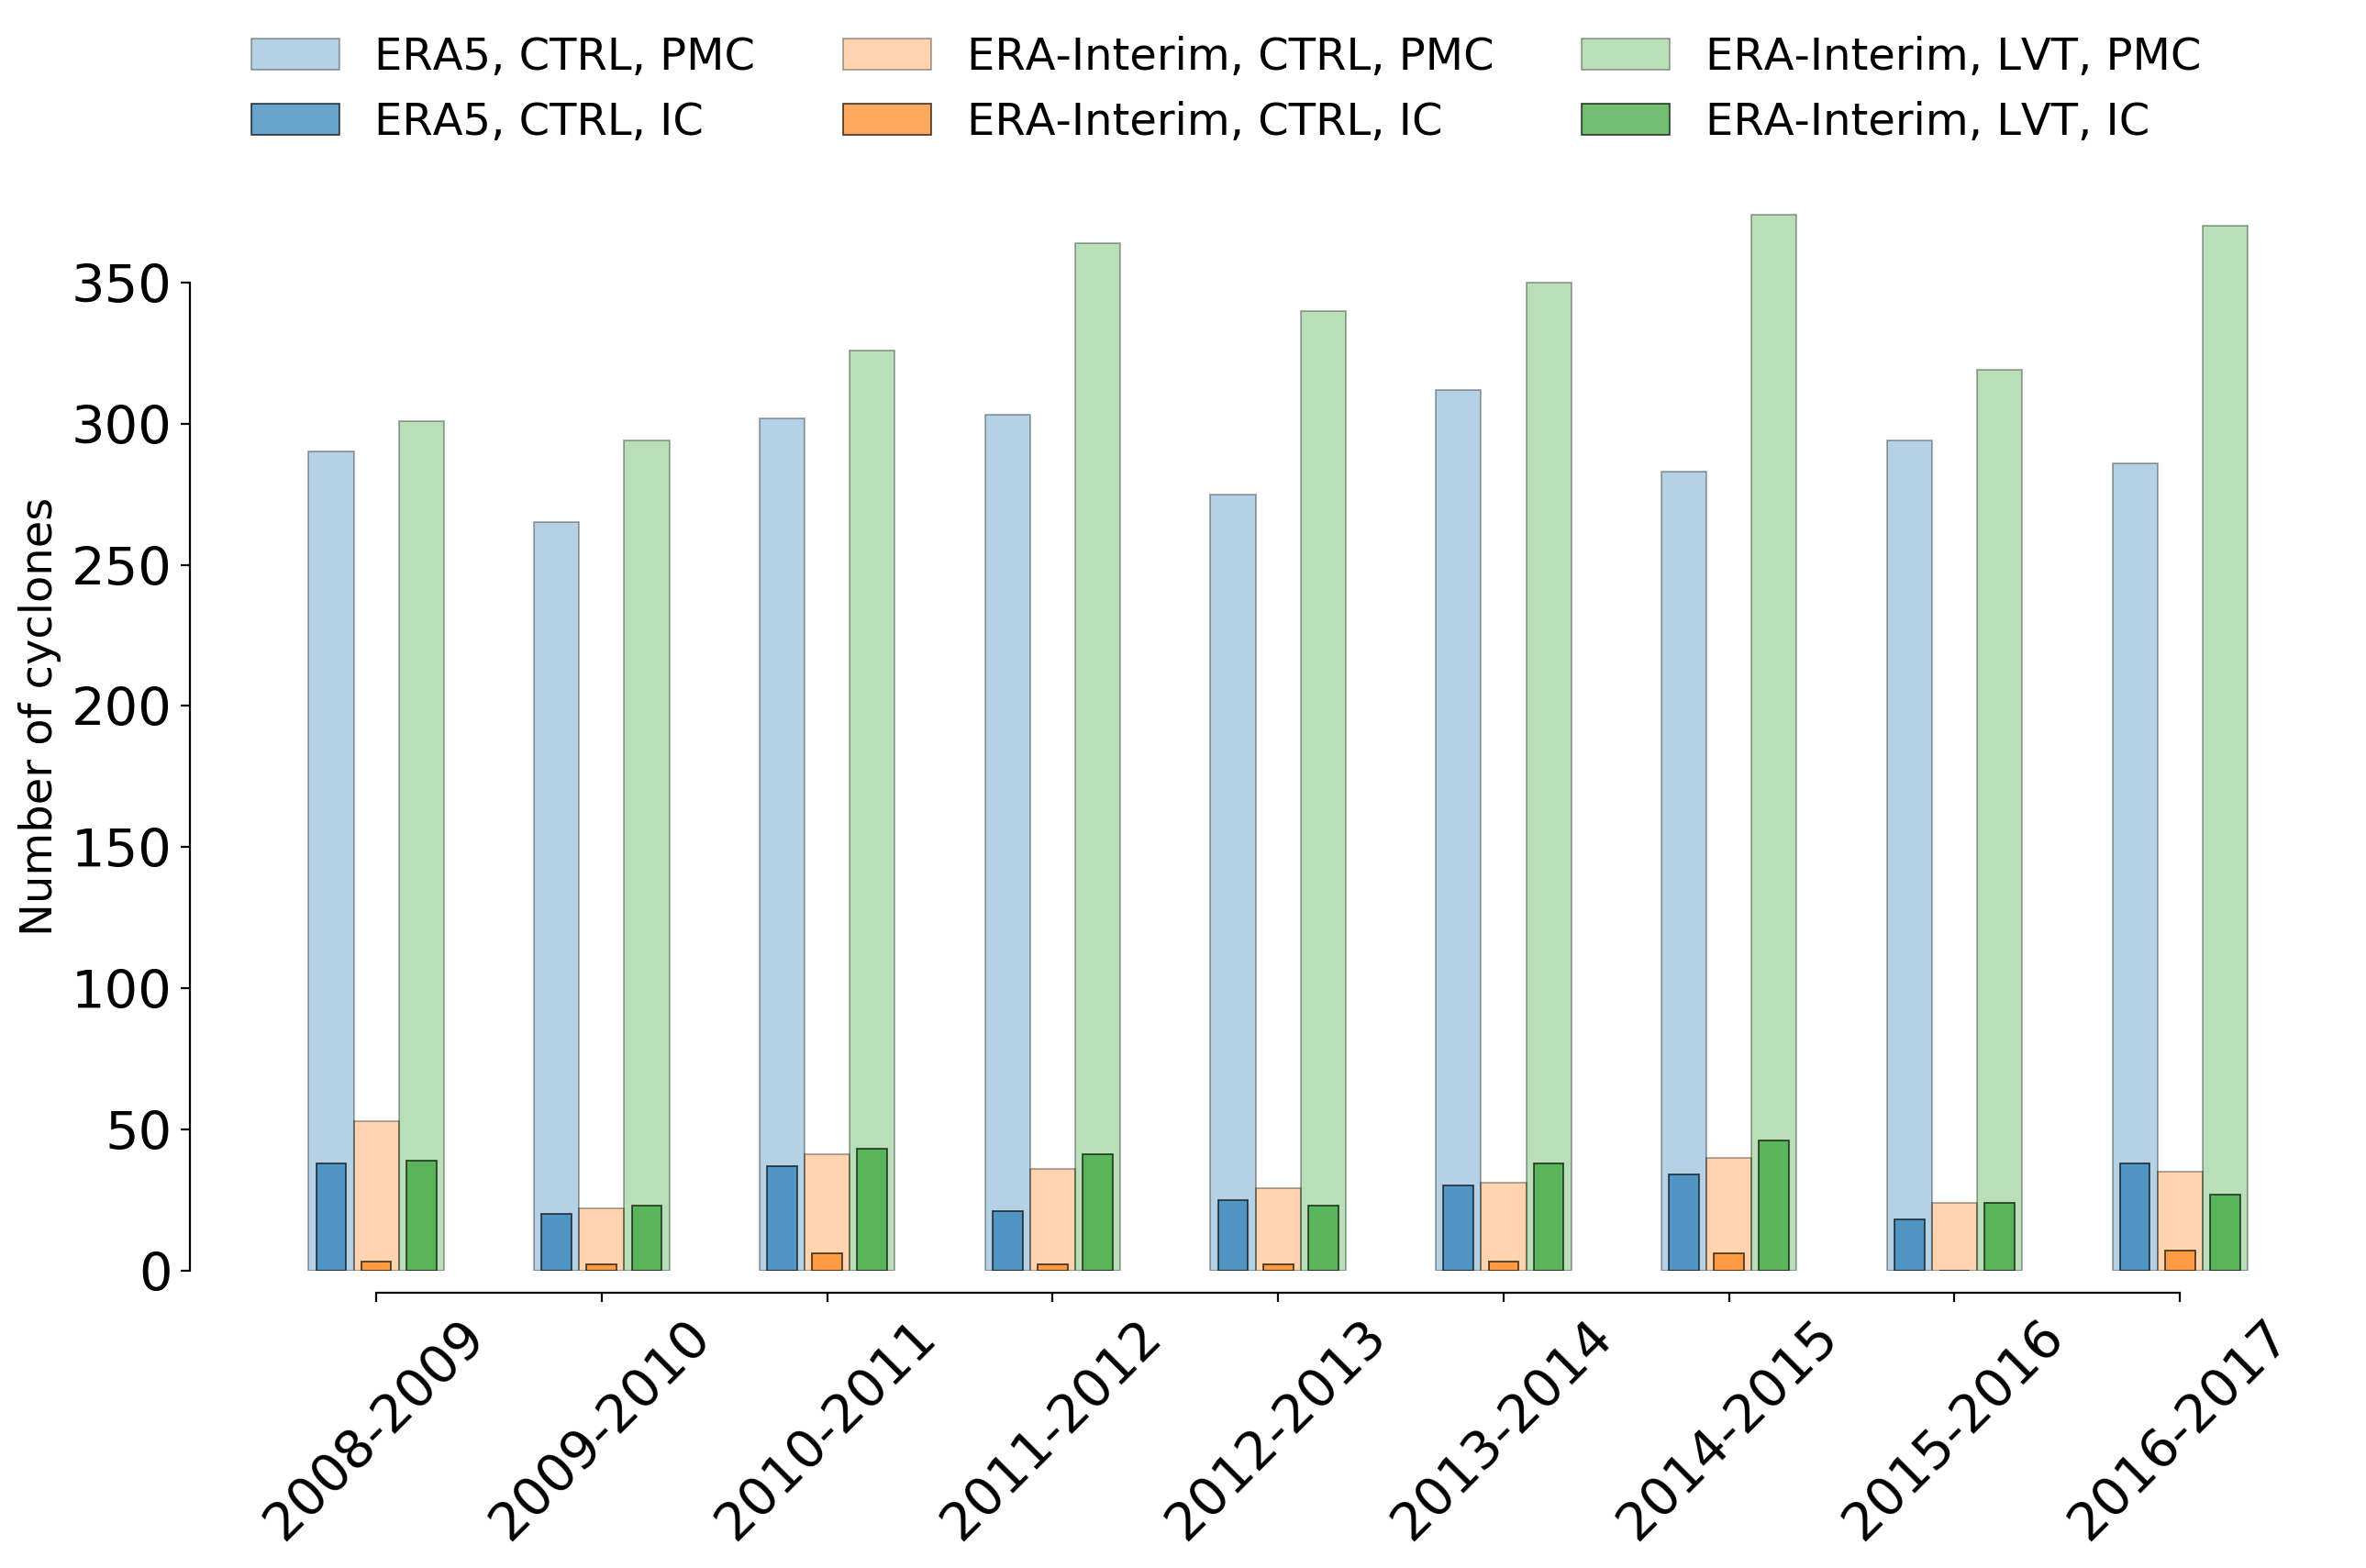

In [94]:
fig, ax = plt.subplots()

for j, ((dset_name, dset_label), color) in enumerate(zip(dset_names, cc)):
    for i, (subset) in enumerate(subsets):
        factor = 1 - i * 1/3
        ax.bar(win_range + (j-1)*width, all_winter_counts[dset_name][subset],
               width=width*factor,
               **color,
               alpha=4/3-factor,
               edgecolor='#000000',
               linewidth=2/3,
               label=f'{dset_label}, {aliases[subset]}')

ax.legend(loc='upper left',
          frameon=False,
          ncol=len(dset_names),
          fontsize='x-large',
          bbox_to_anchor=(0, 1.15))
# ax.set_ylim(0, 150)

ax.set_xticks(win_range)

ax.tick_params(labelsize='xx-large')
ax.set_yticks(np.arange(0, 351, 50))

ax.spines['bottom'].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])
ax.spines['bottom'].set_position(('axes', -0.02))
ax.spines['left'].set_bounds(ax.get_yticks()[0], ax.get_yticks()[-1])
ax.spines['left'].set_position(('axes', -0.01))

ax.set_xticklabels([i.replace('_', '-') for i in  winter_counts.winters], rotation=45)

ax.set_ylabel('Number of cyclones', fontsize='x-large')

In [96]:
fig.savefig(mypaths.plotdir / f'pmctrack_yearly_counts_era5_vs_interim');

In [95]:
for k, TR in track_runs.items():
    for i in ['all'] + SUBSETS:
        print(k, TR.size(i) / nyr)

era5_run000 4437.333333333333
era5_run000 754.2222222222222
era5_run000 290.0
era5_run000 29.0
interim_run106 400.22222222222223
interim_run106 138.44444444444446
interim_run106 34.55555555555556
interim_run106 3.4444444444444446
interim_run100 6232.111111111111
interim_run100 936.0
interim_run100 337.8888888888889
interim_run100 33.77777777777778
